In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.getOrCreate()

In [4]:
msnpc = spark.read.csv("Documents/Visualization/MsNPC.csv", header=True, inferSchema=True)
msplayer = spark.read.csv("Documents/Visualization/MsPlayer.csv", header=True, inferSchema=True)
msweapon = spark.read.csv("Documents/Visualization/MsWeapon.csv", header=True, inferSchema=True)
msweapontype = spark.read.csv("Documents/Visualization/MsWeaponType.csv", header=True, inferSchema=True)
transactiondetail = spark.read.csv("Documents/Visualization/TransactionDetail.csv", header=True, inferSchema=True)
transactionheader = spark.read.csv("Documents/Visualization/TransactionHeader.csv", header=True, inferSchema=True)

msnpc.registerTempTable("MsNPC")
msplayer.registerTempTable("MsPlayer")
msweapon.registerTempTable("MsWeapon")
msweapontype.registerTempTable("MsWeaponType")
transactiondetail.registerTempTable("TransactionDetail")
transactionheader.registerTempTable("TransactionHeader")

In [16]:
res1 = spark.sql("""SELECT MWT.WeaponTypeName, COUNT(TD.WeaponId) as WeaponCount 
                    FROM MsWeaponType MWT JOIN MsWeapon MW ON MWT.WeaponTypeId = MW.WeaponTypeId JOIN TransactionDetail TD ON MW.WeaponId = TD.WeaponId JOIN TransactionHeader TH ON TD.TransactionId = TH.TransactionId 
                    WHERE YEAR(TH.TransactionDate) = 2019 
                    GROUP BY MWT.WeaponTypeName 
                    ORDER BY WeaponCount""")
res1.show()

+--------------+-----------+
|WeaponTypeName|WeaponCount|
+--------------+-----------+
|        Scythe|         45|
|         Flail|         59|
|         Sword|         59|
|           Bow|         66|
|           Axe|         70|
+--------------+-----------+



In [29]:
res1 = res1.toPandas()

In [30]:
res1

,WeaponTypeName,WeaponCount
0,Scythe,45
1,Sword,59
2,Flail,59
3,Bow,66
4,Axe,70


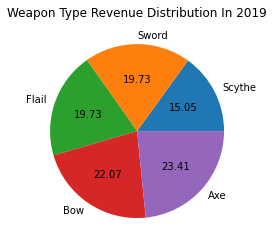

In [31]:
plt.title("Weapon Type Revenue Distribution In 2019")
plt.pie(res1["WeaponCount"], labels=res1["WeaponTypeName"], autopct="%.2f")
plt.show()

In [36]:
res2 = spark.sql("""SELECT COUNT(DISTINCT TH.PlayerId) as PlayerCount, MONTH(TH.TransactionDate) as Month 
                    FROM TransactionHeader TH JOIN TransactionDetail TD ON TH.TransactionId = TD.TransactionId JOIN MsWeapon MW ON TD.WeaponId = MW.WeaponId JOIN MsWeaponType MWT ON MW.WeaponTypeId = MWT.WeaponTypeId 
                    WHERE YEAR(TH.TransactionDate) = 2019 
                    GROUP BY MONTH(TH.TransactionDate) 
                    ORDER BY MONTH(TH.TransactionDate)""")
res2.show()

+-----------+-----+
|PlayerCount|Month|
+-----------+-----+
|         11|    1|
|         10|    2|
|          7|    3|
|          8|    4|
|          5|    5|
|         11|    6|
|         10|    7|
|          9|    8|
|          3|    9|
|         12|   10|
|          4|   11|
|          9|   12|
+-----------+-----+



In [37]:
res2 = res2.toPandas()

In [38]:
res2

,PlayerCount,Month
0,11,1
1,10,2
2,7,3
3,8,4
4,5,5
5,11,6
6,10,7
7,9,8
8,3,9
9,12,10


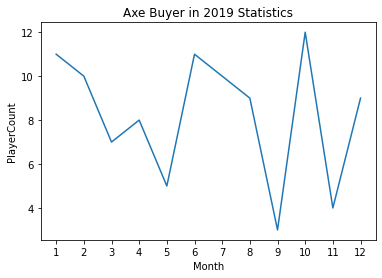

In [39]:
plt.plot(res2["PlayerCount"])
plt.xticks(range(len(res2["Month"])), res2["Month"])
plt.title("Axe Buyer in 2019 Statistics")
plt.xlabel("Month")
plt.ylabel("PlayerCount")
plt.show()

In [124]:
res3 = spark.sql("""SELECT x.MonthlySpending, COUNT(x.MonthlySpending) as Frequency
                    FROM(
                    SELECT 
                    CASE 
                    WHEN SUM(TD.Quantity*MW.WeaponPrice) BETWEEN 1000000 AND 1499999 THEN 'Storm Breaker' 
                    WHEN SUM(TD.Quantity*MW.WeaponPrice) BETWEEN 1500000 AND 1999999 THEN 'Nightfall' 
                    WHEN SUM(TD.Quantity*MW.WeaponPrice) > 2000000 THEN 'Extinction' 
                    ELSE NULL 
                    END AS MonthlySpending
                    FROM MsPlayer MP JOIN TransactionHeader TH ON MP.PlayerId = TH.PlayerId
                    JOIN TransactionDetail TD ON TH.TransactionId = TD.TransactionId JOIN MsWeapon MW ON TD.WeaponId = MW.WeaponId
                    WHERE YEAR(TH.TransactionDate) = 2019 AND MP.PlayerGender LIKE 'Female'
                    GROUP BY TH.PlayerId, TH.TransactionDate
                    HAVING SUM(TD.Quantity*MW.WeaponPrice) >= 1000000) AS x
                    GROUP BY x.MonthlySpending""") 
res3.show()


+---------------+---------+
|MonthlySpending|Frequency|
+---------------+---------+
|  Storm Breaker|       17|
|     Extinction|        7|
|      Nightfall|        9|
+---------------+---------+



In [125]:
res3 = res3.toPandas()

In [126]:
res3

,MonthlySpending,Frequency
0,Storm Breaker,17
1,Extinction,7
2,Nightfall,9


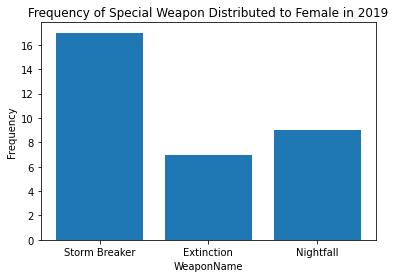

In [128]:
plt.bar(res3["MonthlySpending"], res3["Frequency"])
plt.title("Frequency of Special Weapon Distributed to Female in 2019")
plt.xlabel("WeaponName")
plt.ylabel("Frequency")
plt.show()

In [206]:
res4 = spark.sql("""SELECT COUNT(y.PlayerId) as PlayerCount, y.Month 
                    FROM
                    (SELECT x.PlayerId, COUNT(*) as How_much_type_per_player, x.Month
                    FROM
                    (SELECT WeaponTypeId, PlayerId, MONTH(TransactionDate) as Month
                    FROM TransactionHeader TH JOIN TransactionDetail TD ON TH.TransactionId = TD.TransactionId  
                    JOIN MsWeapon MW ON TD.WeaponId = MW.WeaponId
                    GROUP BY WeaponTypeId, PlayerId, Month) AS x
                    GROUP BY x.PlayerId, x.Month
                    HAVING COUNT(*) > 2) AS y
                    GROUP BY y.Month
                    ORDER BY Month
                    """)
res4.show()

+-----------+-----+
|PlayerCount|Month|
+-----------+-----+
|          6|    1|
|          5|    2|
|          4|    3|
|          3|    4|
|          3|    5|
|          3|    6|
|          5|    7|
|          2|    8|
|          1|    9|
|          5|   10|
|          2|   11|
|          5|   12|
+-----------+-----+



In [207]:
res4 = res4.toPandas()

In [208]:
res4

,PlayerCount,Month
0,6,1
1,5,2
2,4,3
3,3,4
4,3,5
5,3,6
6,5,7
7,2,8
8,1,9
9,5,10


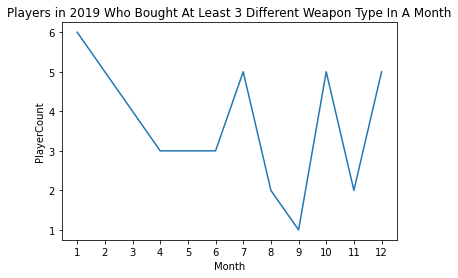

In [209]:
plt.plot(res4["PlayerCount"])
plt.xticks(range(len(res2["Month"])), res2["Month"])
plt.title("Players in 2019 Who Bought At Least 3 Different Weapon Type In A Month")
plt.xlabel("Month")
plt.ylabel("PlayerCount")
plt.show()

In [203]:
res5 = spark.sql("""SELECT z.TotalIncome, COUNT(z.TotalIncome) as Frequency
                    FROM
                    (SELECT CASE
                        WHEN y.Total_Tiap_NPC >= 15000000 THEN 'Very Popular' 
                        WHEN y.Total_Tiap_NPC BETWEEN 7500000 AND 14999999 THEN 'Popular' 
                        WHEN y.Total_Tiap_NPC BETWEEN 2500000 AND 7499999 THEN 'Quite Popular' 
                        ELSE 'Not Popular'
                    END AS TotalIncome
                    FROM
                    (SELECT x.NPC, COUNT(x.PlayerId), SUM(x.Total_Tiap_User) AS Total_Tiap_NPC
                    FROM
                    (SELECT TH.NPCId as NPC, TH.PlayerId, SUM(Quantity * WeaponPrice) as Total_Tiap_User
                    FROM MsNPC MN JOIN TransactionHeader TH ON MN.NPCId = TH.NPCId JOIN TransactionDetail TD ON TH.TransactionId = TD.TransactionId  
                    JOIN MsWeapon MW ON TD.WeaponId = MW.WeaponId 
                    GROUP BY TH.NPCId, TH.PlayerId) AS x
                    GROUP BY x.NPC
                    HAVING COUNT(x.PlayerId) > 4
                    ORDER BY x.NPC DESC) as y) as z
                    GROUP BY z.TotalIncome
                    """)
res5.show()

+-------------+---------+
|  TotalIncome|Frequency|
+-------------+---------+
|Quite Popular|        2|
|      Popular|        8|
| Very Popular|        2|
+-------------+---------+



In [198]:
res5 = res5.toPandas()

In [199]:
res5

,TotalIncome,Frequency
0,Quite Popular,2
1,Popular,8
2,Very Popular,2


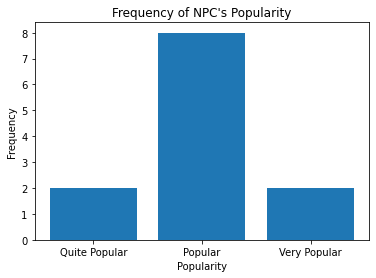

In [200]:
plt.bar(res5["TotalIncome"], res5["Frequency"])
plt.title("Frequency of NPC's Popularity")
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.show()